In [1]:
import h5py
import numpy as np
from keras.models import model_from_json
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau,Callback
import keras as K
from keras import backend as Kb
from keras.models import Model
from keras.layers import Dense, Reshape, BatchNormalization, Bidirectional, GRU,Dropout
from keras.layers import Conv2D, LSTM, Input, TimeDistributed, Lambda, ZeroPadding3D
import tensorflow as tf
from keras.models import load_model

Using TensorFlow backend.


In [2]:
cd ../

/mnt/Stuff/Acads/UGP/mycode


In [3]:
sr = 22050

In [4]:
import math

In [44]:
def construct_model():
    '''
    Construcs the CRNN model
    :param args: Input arguments
    :return: model: Constructed Model object
    '''
    number_of_patches = 20
    patch_size = 50
    feature_size = 301
    number_of_classes = 61
    step_notes = 5
    RNN = 'LSTM'
    verbose = False

    kernel_coeff = 0.00001

    number_of_channels = 1
    input_shape = (number_of_patches, patch_size, feature_size, number_of_channels)

    inputs = Input(shape=input_shape)

#     zp = ZeroPadding3D(padding=(0, 0, 2))(inputs)

#     #### CNN LAYERS ####
#     cnn1 = TimeDistributed(Conv2D(64, (1, 5),
#                                   padding='valid',
#                                   activation='relu',
#                                   strides=(1, np.int(step_notes)),
#                                   kernel_regularizer=K.regularizers.l2(kernel_coeff),
#                                   data_format='channels_last', name='cnn1'))(zp)

#     cnn1a = BatchNormalization()(cnn1)

#     zp = ZeroPadding3D(padding=(0, 1, 2))(cnn1a)

#     cnn2 = TimeDistributed(
#         Conv2D(64, (3, 5), padding='valid', activation='relu', data_format='channels_last', name='cnn2'))(zp)

#     cnn2a = BatchNormalization()(cnn2)

#     zp = ZeroPadding3D(padding=(0, 1, 1))(cnn2a)

#     cnn3 = TimeDistributed(
#         Conv2D(64, (3, 3), padding='valid', activation='relu', data_format='channels_last', name='cnn3'))(zp)

#     cnn3a = BatchNormalization()(cnn3)

#     zp = ZeroPadding3D(padding=(0, 1, 7))(cnn3a)

#     cnn4 = TimeDistributed(
#         Conv2D(16, (3, 15), padding='valid', activation='relu', data_format='channels_last', name='cnn4'))(zp)

#     cnn4a = BatchNormalization()(cnn4)

#     cnn5 = TimeDistributed(
#         Conv2D(1, (1, 1), padding='same', activation='relu', data_format='channels_last', name='cnn5'))(cnn4a)

#     #### RESHAPING LAYERS ####
    cnn5a = Lambda(lambda x: Kb.squeeze(x, axis=4))(inputs)

    cnn5b = Reshape((number_of_patches * patch_size, -1), name='cnn5-reshape')(cnn5a)

    #### BIDIRECTIONAL RNN LAYERS ####
    if RNN == 'LSTM':
        rnn1 = Bidirectional(LSTM(128,
                                  kernel_regularizer=K.regularizers.l1_l2(0.0001),
                                  return_sequences=True), name='rnn1')(cnn5b)
    elif RNN == 'GRU':
        rnn1 = Bidirectional(GRU(128,
                                 kernel_regularizer=K.regularizers.l1_l2(0.0001),
                                 return_sequences=True), name='rnn1')(cnn5b)

    #### CLASSIFICATION (DENSE) LAYER ####
    classifier = TimeDistributed(Dense(number_of_classes,
                                       activation='softmax',
                                       kernel_regularizer=K.regularizers.l2(0.00001),
                                       bias_regularizer=K.regularizers.l2()), name='output')(rnn1)

    model = Model(inputs=inputs, outputs=classifier)

    if verbose == True:
        model.summary()

        print('{0} as RNN!'.format(RNN))

    return model

In [45]:
model = construct_model()

In [47]:
# json_file = open('model4.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)
model.load_weights("model5.h5")

In [5]:
def song(sp, gp):

    HF0 = np.load(sp)
    #HF0 = HF0['arr_0']
    ground = np.load(gp)
    #print(gp)
    T = HF0.shape[1]
    # if T != ground.shape[0]:
    #     print(T, ground.shape[0])
    #     print('ground dimension error')

    gr = np.zeros([61,T])
    for t in range(T):
        if ground[t] != 0:
            gr[int(ground[t]) , t] = 1
            #print(int(ground[t] ))

    patches_size = 50
    number_of_patches = math.floor(T/patches_size)
    # print(number_of_patches)

    x = np.zeros([number_of_patches,patches_size,301])
    y = np.zeros([number_of_patches,patches_size,61])

    j = 0
    for i in range(T):
        if i%patches_size == 0 and i !=0:
            j+=1
        if j +1 == number_of_patches:
            break
        x[j] = np.swapaxes(HF0[:,i:i+patches_size] , 0 , 1)
        y[j] = np.swapaxes(gr[:,i:i+patches_size] , 0,1)
    # print(y.shape)
    return x , y

In [7]:
def generator(names):
    sp = '/mnt/data/datasets/outs_hf/out_'
    gp = 'ground/'
    indices = np.arange(names.shape[0])
    while True:
        np.random.shuffle(indices)

        # if train:
        #     names = train_names
        # else:
        #     names = val_names
        count=0
        batch_size = 10
        patch_size = 50
        x_train_batch = np.zeros([batch_size , 20 , patch_size , 301 , 1 ])
        y_train_batch = np.zeros([batch_size , patch_size * 20 , 61])
        batch_count = 0
        for i in indices:
            name = names[i]
            print(name)
            x, y = song(sp + name[:-1] + 'y', gp + name[:-1] + 'y')

            return x , y
            number_of_patches = 20
            

            i = 0
            while (i+1)*number_of_patches <= x.shape[0]:
                count+=1


                x_train = np.reshape(
                            x[i*number_of_patches : (i+1)*number_of_patches,:,:] ,
                            [20 , patch_size , 301 , 1 ])
                y_train = np.zeros([number_of_patches * patch_size , 61])
                for j in range(number_of_patches):
                    y_train[j*patch_size : (j+1)*patch_size,  : ] = y[i+j]

                #print(y_train.shape)
                y_train = np.reshape(
                            y_train, [number_of_patches * patch_size , 61])

                i+=1

                if batch_count < batch_size:
                    x_train_batch[batch_count] = x_train
                    y_train_batch[batch_count] = y_train
                    batch_count +=1
                else:
                    batch_count = 0
                    return x_train_batch, y_train_batch


        print()
        print(count)
        print()

In [8]:
names = np.load('names.npy')
l = names.shape[0]
train_names = names#[:int(0.8*l)]
val_names = names[int(0.8*l):]
x , y = generator(train_names)

MusicDelta_Zeppelin.npz


In [9]:
x.shape

(30, 50, 301)

In [12]:
HF0 = np.swapaxes(x[10],0,1)

In [10]:
y.shape

(30, 50, 61)

In [13]:
gr = np.swapaxes(y[10],0,1)

In [15]:
fund_bad = np.zeros([U,N])
for i in range(N):
    m = np.amax(HF0[:,i])
    mi = np.argwhere(HF0[:,i] == m)
    for x in mi:
        fund_bad[x,i] = m

NameError: name 'U' is not defined

In [11]:
import librosa
import librosa.display as display
import matplotlib.pyplot as plt

In [ ]:
a = np.random.rand(1 , 5 , 200 , 301 , 1)

In [ ]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.power_to_db(np.swapaxes(x[0,5,:,:,0],0,1), ref=np.max),
                           y_axis='linear',x_axis='time', sr=sr,hop_length=256)
plt.colorbar()
plt.tight_layout()

In [ ]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.power_to_db(np.swapaxes(y[0],0,1), ref=np.max),
                           y_axis='linear',x_axis='time', sr=sr,hop_length=256)
plt.colorbar()
plt.tight_layout()

In [48]:
o = model.predict(x)

In [49]:
o.shape

(10, 1000, 61)

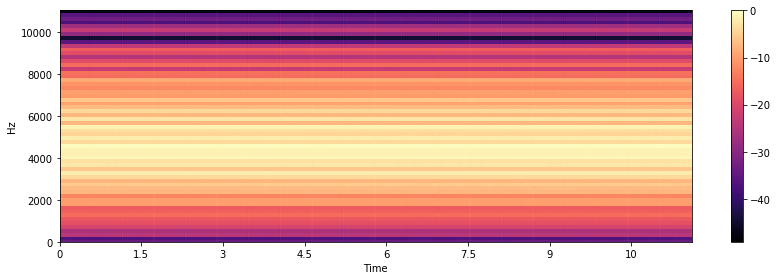

In [42]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.power_to_db(np.swapaxes(o[7],0,1), ref=np.max),
                           y_axis='linear',x_axis='time', sr=sr,hop_length=256)
plt.colorbar()
plt.tight_layout()

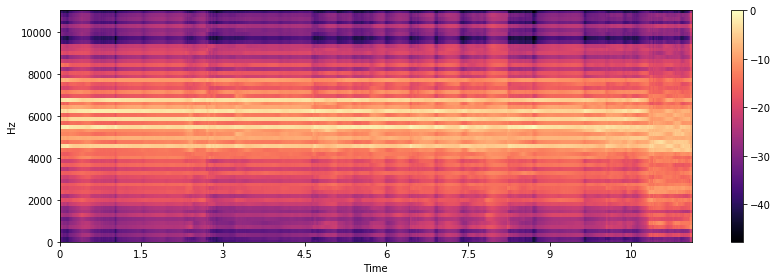

In [50]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.power_to_db(np.swapaxes(o[7],0,1), ref=np.max),
                           y_axis='linear',x_axis='time', sr=sr,hop_length=256)
plt.colorbar()
plt.tight_layout()

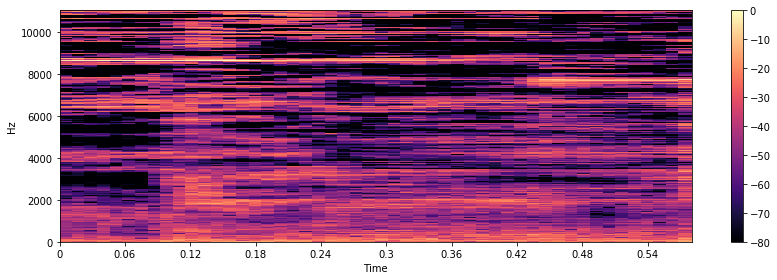

In [43]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.power_to_db(np.swapaxes(x[7,0,:,:,0],0,1), ref=np.max),
                           y_axis='linear',x_axis='time', sr=sr,hop_length=256)
plt.colorbar()
plt.tight_layout()